# Pedestrian Detection with SVM (Support Vector Machines)

# 💻 **Used Libraries**

- **glob:** This library is used to find all files that match a specified pattern. In your case, it might be used to find and load images of pedestrians and non-pedestrians from one or more directories.

- **os:** The os library is essential for interacting with the operating system. It can be used to manipulate file paths, create directories, check the existence of files, etc. In your code, it is probably used for file-related operations, such as reading image files.

- **tarfile:** This library provides operations for tar files, which are commonly used to compress files and directories on Unix systems. You might be using this to extract images from a compressed tar file containing your datasets.

- **cv2:** OpenCV is a popular library for computer vision and image processing. You are likely using it to load and preprocess images, such as resizing, converting to grayscale, or applying other filters needed for feature extraction.

- **matplotlib:** This library is commonly used for data visualization in Python. In your code, it might be used to display images and plots, which can be useful for data exploration and result evaluation.

- **numpy:** NumPy is a fundamental library for numerical computing in Python. It is used to perform mathematical operations on arrays and multidimensional arrays. In the context of your code, it might be used to manipulate and process image data.

- **requests:** This library allows you to make HTTP requests in Python. In your code, it might be used to download images from a URL if your data is hosted online.

- **seaborn:** Seaborn is a data visualization library based on matplotlib. It is used to create attractive and informative statistical graphics. In your code, it might be used to visualize the confusion matrix or other graphs related to model evaluation.

- **skimage:** This library provides a collection of algorithms for image processing. In particular, the skimage.feature module provides tools for feature extraction, such as the Histogram of Oriented Gradients (HOG), which is useful in object detection in images.

- **scikit-learn:** Scikit-learn is a machine learning library in Python that provides efficient implementations of a wide range of machine learning algorithms. In your code, you are using sklearn.svm to train a support vector machine (SVM) model for pedestrian detection.



In [ ]:
!pip install scikit-learn-intelex

In [ ]:
!pip install scikit-image

In [ ]:
import glob
import os
import tarfile
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
from skimage.feature import hog
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

# Estas librerías son para optimizar la librería de sklearnex cuando 
# from sklearnex import patch_sklearn 
# patch_sklearn()

## 🚀 **Loading the Dataset**

---

The dataset was obtained from: http://www.gavrila.net/Datasets/Daimler_Pedestrian_Benchmark_D/Daimler_Mono_Ped__Class__Bench/daimler_mono_ped__class__bench.html. It contains images of pedestrians and non-pedestrians, which will be very useful for training our model. Since the dataset comes in .tar.gz format, the following function downloads it directly from the URL and extracts the images into the specified folder.

In [ ]:
def download_and_extract_dataset(url: str, target_dir: str):
    """
    Descarga y extrae un conjunto de datos en formato tar.gz desde una URL en el directorio especificado.

    Args:
        url (str): La URL de donde se descargará el conjunto de datos.
        target_dir (str): El directorio donde se guardará el conjunto de datos.
    """
    # Revisar que el directorio objetivo existe
    os.makedirs(target_dir, exist_ok=True)

    # Establece la ruta donde se guardará el conjunto de datos
    filename = url.split("/")[-1]
    file_path = os.path.join(target_dir, filename)

    # Verifica si el archivo ya existe
    if not os.path.exists(file_path):
        print("Descargando el conjunto de datos...")
        # Envía una solicitud GET a la URL
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            # Guarda el archivo en fragmentos para evitar usar demasiada memoria
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Descarga completa. Extrayendo archivos...")
            # Extrae el archivo tar.gz
            with tarfile.open(file_path, "r:gz") as tar:
                tar.extractall(path=target_dir)
            print("Extracción completa.")
        else:
            print("Fallo al descargar el archivo. Código de estado:", response.status_code)
    else:
        print("El conjunto de datos ya existe.")

Function Execution

In [ ]:
dataset_url = "http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/DC-ped-dataset_base.tar.gz"
dataset_target_dir = "data/pedestrians"

download_and_extract_dataset(dataset_url, dataset_target_dir)

Descargando el conjunto de datos...
Descarga completa. Extrayendo archivos...
Extracción completa.


# 📝 **Training and Testing Data**

---

According to the dataset description found on the following page: http://www.lookingatpeople.com/data/Daimler/pami06-munder-gavrila/README_benchmark.txt, the dataset has the following structure:

| **Dataset Name** | **Purpose** | **Pedestrian Labels** | **Pedestrian Examples** | **Non-ped. Examples** | **Storage Size** |
|------------------|-------------|-----------------------|-------------------------|-----------------------|------------------|
| 1                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| 2                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| 3                | Training    | 800                   | 4800                    | 5000                  | 39 MB            |
| T1               | Test        | 800                   | 4800                    | 5000                  | 39 MB            |
| T2               | Test        | 800                   | 4800                    | 5000                  | 39 MB            |


We obtain our data and will explain a bit about the function.

This function called `get_data_files` is responsible for obtaining a list of data files based on certain parameters it receives as input. Let's look at the details:

- **sub_dir:** This parameter is a string that represents the subdirectory where the data files will be searched. It is the specific directory where the relevant files are expected to be found.

- **sub_dirs:** This parameter is a list of strings that contains the names of the subdirectories within `sub_dir` where the data files will be searched. This allows searching in multiple subdirectories within `sub_dir` simultaneously.

- **file_extension:** This parameter is a string that specifies the file extension of the files being searched for. By default, it is set to 'pgm'.

The function uses the `glob` library to perform the file search in the file system. Basically, `glob.glob()` returns a list of filenames that match a specified pattern.

Inside the function, an empty list called `data` is initialized, which will be used to store the names of the files found.

Then, it iterates over each `sub_dir` in `sub_dirs`. For each `sub_dir`, `glob.glob()` is used to find all files with the specified extension `(file_extension)` within the corresponding subdirectory. These filenames are stored in the variable `data_files`.

Finally, the filenames found in `data_files` are added to the `data` list using the `extend()` method, which allows adding multiple elements to a list.

The function returns the `data` list, which contains the names of all the files found in the specified subdirectories.


In [ ]:
def get_data_files(sub_dir: str, sub_dirs: str, file_extension: str='pgm') -> list:
    data = []
    for sub_dir in sub_dirs:
        data_files = glob.glob(f"{dataset_target_dir}/{sub_dir}/*.{file_extension}")
        data.extend(data_files)
    return data

## **Training Data**

---

Training files for the pedestrian class `(pedestrians)`.

- **train_pedestrians_sub_dirs:** This is a list containing the names of the subdirectories where the pedestrian examples are located within the training dataset. Each subdirectory name is in the format `"number/ped_examples"`, which suggests that the pedestrian examples are organized in numbered subdirectories.

- **train_pedestrians:** This line of code calls the `get_data_files()` function. It passes the main dataset directory `(dataset_target_dir)` and the list of pedestrian subdirectories `(train_pedestrians_sub_dirs)`. This function returns a list containing the names of all pedestrian example files found in the specified subdirectories.

- **len(train_pedestrians):** This simply calculates the length of the `train_pedestrians` list, i.e., the total number of pedestrian example files found in the specified subdirectories.

For this particular case, we have 14,400 pedestrians.

In [ ]:
train_pedestrians_sub_dirs = ["1/ped_examples", "2/ped_examples", "3/ped_examples"]
train_pedestrians = get_data_files(dataset_target_dir, train_pedestrians_sub_dirs)
len(train_pedestrians)

14400

For this other case, it works similarly:

- **train_non_pedestrians_sub_dirs:** Similar to the previous case, this is a list containing the names of the subdirectories where the `non-pedestrian` examples are located within the training dataset.

- **train_non_pedestrians:** As before, this line calls the `get_data_files()` function with the main dataset directory and the list of non-pedestrian subdirectories. This function returns a list containing the names of all non-pedestrian example files found in the specified subdirectories.

- **len(train_non_pedestrians):** Again, this calculates the length of the `train_non_pedestrians` list, i.e., the total number of non-pedestrian example files found in the specified subdirectories.

In [ ]:
train_non_pedestrians_sub_dirs = ["1/non-ped_examples", "2/non-ped_examples", "3/non-ped_examples"]
train_non_pedestrians = get_data_files(dataset_target_dir, train_non_pedestrians_sub_dirs)
len(train_non_pedestrians)

15000

## **Testing Data**

---

In [ ]:
test_pedestrians_sub_dirs = ["T1/ped_examples", "T2/ped_examples"]
test_pedestrians = get_data_files(dataset_target_dir, test_pedestrians_sub_dirs)
len(test_pedestrians)

9600

In [ ]:
test_non_pedestrians_sub_dirs = ["T1/non-ped_examples", "T2/non-ped_examples"]
test_non_pedestrians = get_data_files(dataset_target_dir, test_non_pedestrians_sub_dirs)
len(test_non_pedestrians)

10000

# 👓 **Calculation of HOG on a Single Image**

---

Visualization of a single pedestrian image using `cv2`, detailed below:

- `cv2.imread(train_pedestrians[170], cv2.COLOR_BGR2GRAY)`: Uses the `cv2.imread()` function from **OpenCV** to read an image from the pedestrian training dataset. `train_pedestrians[170]` provides the file path of the specific image to be loaded. Additionally, `cv2.COLOR_BGR2GRAY` is specified as the second argument, indicating that the image will be loaded in grayscale. This means the image will be converted to a single-layer representation `(grayscale)` instead of a color image. The result is stored in the variable `img_pedestrian`.

- `plt.imshow(img_pedestrian, cmap='gray')`: Uses the `plt.imshow()` function from **Matplotlib** to display the loaded image. `img_pedestrian` is the image to be displayed. `cmap='gray'` is specified to indicate that the image should be displayed in grayscale. This ensures that the image is shown correctly, as it was loaded in grayscale in the previous step.

- `plt.show()`: This line displays the image in a viewing window.


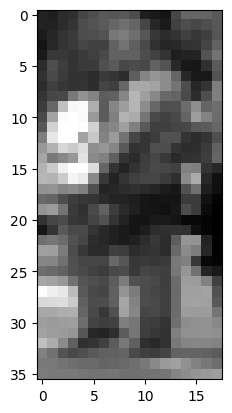

In [ ]:
img_pedestrian = cv2.imread(train_pedestrians[170], cv2.COLOR_BGR2GRAY)
plt.imshow(img_pedestrian, cmap='gray')
plt.show()

Image shape visualization

In [ ]:
print(img_pedestrian.shape)

(36, 18)


Let's calculate the `Histogram of Oriented Gradients (HOG)` for a pedestrian image. Here is what each argument means and how it contributes to the HOG calculation:

- **img_pedestrian:** This is the pedestrian image on which the HOG will be calculated. It is the image you previously loaded using `OpenCV` and converted to grayscale.

- **orientations:** This parameter specifies the number of orientation bins into which the `gradient angle` will be divided. In this case, it is set to 10, meaning the `gradient angle` will be divided into `10 bins`.

- **pixels_per_cell:** This parameter sets the size of the cell in which the gradient histogram will be computed. It is specified as a tuple of two values, where the first value represents the number of pixels in the horizontal direction and the second value represents the number of pixels in the vertical direction. In this case, it is set to `(6, 6)`, meaning 6x6 pixel cells will be used.

- **cells_per_block:** This parameter sets the size of the block over which the gradient histograms will be normalized. It is also specified as a tuple of two values, where the first value represents the number of cells in the block in the horizontal direction and the second value represents the number of cells in the block in the vertical direction. In this case, it is set to `(2, 2)`, meaning gradient histograms will be normalized over 2x2 cell blocks.

- **transform_sqrt:** This parameter indicates whether to apply a square root transformation to the histograms before normalizing them. In this case, it is set to False, meaning no additional transformation will be applied.

- **visualize:** This parameter specifies whether to return an image of the gradient orientations. In this case, it is set to True, meaning an image of the gradient orientations will be computed and returned.

- **feature_vector:** This parameter indicates whether to flatten the HOG result into a one-dimensional vector. In this case, it is set to True, meaning the HOG result will be returned as a one-dimensional feature vector.

The result of the HOG calculation are two values:

- **features:** This is the one-dimensional feature vector resulting from the HOG calculation.
- **hog_image:** This is an image that visualizes the gradient orientations. This image can be useful for visualizing how the HOG features are being computed on the original image.


In [ ]:
features, hog_image = hog(img_pedestrian,
                          orientations=10,
                          pixels_per_cell=(6, 6),
                          cells_per_block=(2, 2),
                          transform_sqrt= False,
                          visualize=True,
                          feature_vector=True)

In [ ]:
print(features.shape)

(400,)


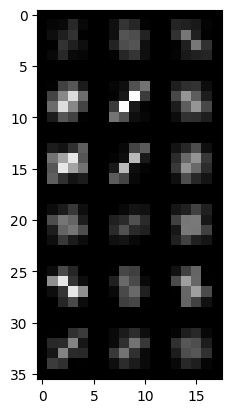

In [ ]:
plt.imshow(hog_image, cmap='gray')
plt.show()

# 🧐 **Extracting HOG Features for the Data**

---

Let's start by defining a function that extracts Histogram of Oriented Gradients (HOG) features from a list of images, consisting of the following parameters:

- **def extract_hog_features(img_data_list: list) -> list::**
  - **def:** Defines a new function.
  - **extract_hog_features:** This is the name of the function.
  - **(img_data_list: list) -> list:** Specifies that the function takes a list of image data as input and returns a list of HOG features.
  - **hog_data = list():** Initializes an empty list called hog_data. This list will be used to store the HOG features of each processed image.

- **for img_data in img_data_list::** This loop iterates over each element in the provided image data list.

- **img = cv2.imread(img_data, cv2.COLOR_BGR2GRAY):** Loads the image using `OpenCV (cv2.imread())`. The parameter `cv2.COLOR_BGR2GRAY` indicates that the image will be loaded in grayscale. The loaded image is assigned to the variable img.

- **img_hog_feature, img_hog_image = hog(img, orientations=10, pixels_per_cell=(6, 6), cells_per_block=(2, 2), transform_sqrt=False, visualize=True, feature_vector=True):** Computes the HOG features of the image using the `hog()` function from the `skimage.feature` module. The specified parameters are similar to those explained earlier. It returns both the HOG features `(img_hog_feature)` and an image of the gradient orientations `(img_hog_image)`.

- **hog_data.append(img_hog_feature):** Adds the HOG features of the current image to the hog_data list.

- **return hog_data:** Returns the hog_data list, which contains the HOG features of all processed images.

In [ ]:
def extract_hog_features(img_data_list: list) -> list:
    hog_data = list()
    for img_data in img_data_list:
        img = cv2.imread(img_data, cv2.COLOR_BGR2GRAY)
        img_hog_feature, img_hog_image = hog(img,
                                             orientations=10,
                                             pixels_per_cell=(6, 6),
                                             cells_per_block=(2, 2),
                                             transform_sqrt= False,
                                             visualize=True,
                                             feature_vector=True)
        hog_data.append(img_hog_feature)

    return hog_data

Now, let's prepare the training data for the support vector machine (SVM) model that will be used for pedestrian detection. To better understand the process, let's explain it:

- **Extraction of HOG features for pedestrians and non-pedestrians:**

  - **X_train_pedestrians = np.vstack(extract_hog_features(train_pedestrians)).astype(np.float32):** Extracts the HOG features for the pedestrian images in the training set `(train_pedestrians)`. These features are stacked vertically using `np.vstack()`, which means they are combined into a single array. They are converted to `np.float32` type to ensure calculation precision.
  - **y_train_pedestrians = np.ones(len(X_train_pedestrians)):** Creates a label array for the pedestrian images, setting all labels to `1 (indicating they are pedestrians)`.

  - **X_train_non_pedestrians = np.vstack(extract_hog_features(train_non_pedestrians)).astype(np.float32):** A similar process is performed for the non-pedestrian images `(train_non_pedestrians)`. The HOG features are extracted, stacked vertically, and converted to `np.float32` type.
  - **y_train_non_pedestrians = np.zeros(len(X_train_non_pedestrians)):** Creates a label array for the non-pedestrian images, setting all labels to `0 (indicating they are not pedestrians)`.

- **Combining pedestrian and non-pedestrian data:**

  - **X_train = np.vstack((X_train_pedestrians, X_train_non_pedestrians)):** Combines the HOG features of pedestrians and non-pedestrians into a single array vertically.
  - **y_train = np.hstack((y_train_pedestrians, y_train_non_pedestrians)):** Combines the labels of pedestrians and non-pedestrians into a single array horizontally.

- **Randomizing the data:**

  - **random_state = np.random.RandomState(seed=42):** Initializes a random number generator with a fixed seed to ensure reproducibility of results.
  - **indices = random_state.permutation(len(X_train)):** Generates random indices for the training data.
  - **X_train_shuffled = X_train[indices]:** Randomly rearranges the training feature data.
  - **y_train_shuffled = y_train[indices]:** Rearranges the training labels according to the shuffled feature data.


In [ ]:
X_train_pedestrians = np.vstack(extract_hog_features(train_pedestrians)).astype(np.float32)
y_train_pedestrians = np.ones(len(X_train_pedestrians))

X_train_non_pedestrians = np.vstack(extract_hog_features(train_non_pedestrians)).astype(np.float32)
y_train_non_pedestrians = np.zeros(len(X_train_non_pedestrians))

X_train = np.vstack((X_train_pedestrians, X_train_non_pedestrians))
y_train = np.hstack((y_train_pedestrians, y_train_non_pedestrians))

# Poner datos de forma aleatoria
random_state = np.random.RandomState(seed=42)
indices = random_state.permutation(len(X_train))
X_train_shuffled = X_train[indices]
y_train_shuffled = y_train[indices]

Now let's remove the variables that contain the labels/features from the training set:

In [ ]:
del X_train
del y_train
del train_pedestrians
del train_non_pedestrians

Next, we will prepare the test data, which works very similarly to the structure used for the training data.


In [ ]:
X_test_pedestrians = np.vstack(extract_hog_features(test_pedestrians)).astype(np.float32)
y_test_pedestrians = np.ones(len(X_test_pedestrians))

X_test_non_pedestrians = np.vstack(extract_hog_features(test_non_pedestrians)).astype(np.float32)
y_test_non_pedestrians = np.zeros(len(X_test_non_pedestrians))

X_test = np.vstack((X_test_pedestrians, X_test_non_pedestrians))
y_test = np.hstack((y_test_pedestrians, y_test_non_pedestrians))

# Poner datos de forma aleatoria
indices = random_state.permutation(len(X_test))
X_test_shuffled = X_test[indices]
y_test_shuffled = y_test[indices]

We finish by removing the variables that contain the labels/features from the test set.

In [ ]:
del X_test
del y_test
del test_pedestrians
del test_non_pedestrians

# 💪 **SVM Model and Training**

---

Let's create and train a Support Vector Machine (SVM) model using the randomized training data `X_train_shuffled` and `y_train_shuffled`, which includes the following:

- **Creating the SVC model:**

  - **svc_model = SVC():** Instantiates an object of the SVC class from the `sklearn.svm` module. By default, this constructor creates an SVM model with an RBF (Radial Basis Function) kernel. This model will be used to classify the input data into specific categories `(in this case, pedestrians and non-pedestrians)`.

- **Training the model:**

  - **svc_model.fit(X_train_shuffled, y_train_shuffled):** Uses the `fit()` method of the `svc_model` object to train the SVM model using the randomized training data `X_train_shuffled` as features and `y_train_shuffled` as labels. During training, the model learns to classify the input data into the specified categories `(1 for pedestrians and 0 for non-pedestrians)` using the Support Vector Machine algorithm.

In [ ]:
svc_model = SVC()
svc_model.fit(X_train_shuffled, y_train_shuffled)

SVC()

Now let's make predictions on the randomized test data `X_test_shuffled`:

- **y_pred = svc_model.predict(X_test_shuffled):** Uses the `predict()` method of the `svc_model` to make predictions on the randomized test features `X_test_shuffled`. This method takes the test features as input and returns the predicted labels for those features.

In [ ]:
y_pred = svc_model.predict(X_test_shuffled)

In [ ]:
# Guardar el modelo resultante
joblib.dump(svc_model, 'svc_model.pkl')

['svc_model.pkl']

# 🔎 **Model Metrics Validation**

---

Let's generate a confusion matrix and visualize it as a heatmap using the Seaborn and Matplotlib libraries, as follows:

- **cm = confusion_matrix(y_test_shuffled, y_pred, labels=[0, 1]):** Calculates the confusion matrix using the `confusion_matrix()` function from `Scikit-learn`. This matrix compares the true labels `y_test_shuffled` with the predicted labels `y_pred`. The confusion matrix is a tool that shows **the number of correct and incorrect predictions** for each class `(in this case, 0 for non-pedestrians and 1 for pedestrians)`. The `labels=[0, 1]` parameter is used to specify the order of the labels in the confusion matrix.

- **sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False):** Uses the `heatmap()` function from Seaborn to visualize the confusion matrix `cm` as a heatmap. The parameters used are:

  - **cm:** The confusion matrix to visualize.
  - **annot=True:** Adds annotations to the cells of the heatmap to show the values of the confusion matrix.
  - **fmt='g':** Sets the format of the annotations to general format.
  - **cmap='Purples':** Uses the 'Purples' color scheme for the heatmap, which is a color palette ranging from light to dark purple tones.
  - **cbar=False:** Disables the side color bar in the heatmap.
  - **plt.show():** Displays the generated heatmap using the `show()` function from Matplotlib.

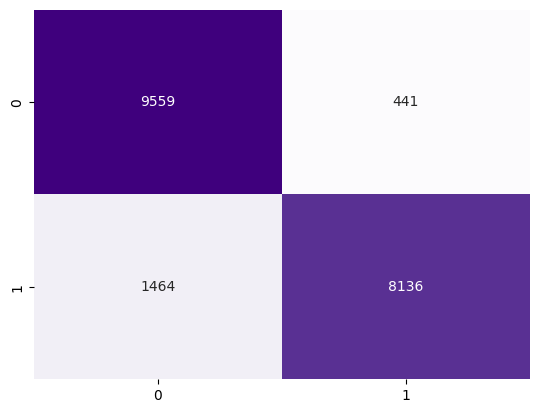

In [ ]:
cm = confusion_matrix(y_test_shuffled, y_pred, labels=[0, 1])
sns.heatmap(cm,  annot=True, fmt='g', cmap='Purples', cbar=False)
plt.show()

- **True Negatives (TN): 9559**

  These are cases where the model correctly predicted that the samples did not belong to the pedestrian class (negative class).

- **False Positives (FP): 441**

  These are cases where the model incorrectly predicted that the samples belonged to the pedestrian class when they actually did not. That is, the model gave a positive result when the truth was negative.

- **False Negatives (FN): 1464**

  These are cases where the model incorrectly predicted that the samples did not belong to the pedestrian class when they actually did. That is, the model gave a negative result when the truth was positive.

- **True Positives (TP): 8136**

  These are cases where the model correctly predicted that the samples belonged to the pedestrian class (positive class).

To interpret these results:

- The model correctly classified `9559` samples as `non-pedestrians`.
- The model incorrectly classified `441` samples as `pedestrians` when they actually were `not`.
- The model incorrectly classified `1464` samples as `non-pedestrians` when they actually were `pedestrians`.
- The model correctly classified `8136` samples as `pedestrians`.


In [ ]:
print(cm)

[[9559  441]
 [1464 8136]]


In [ ]:
print(classification_report(y_test_shuffled, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10000
         1.0       0.95      0.85      0.90      9600

    accuracy                           0.90     19600
   macro avg       0.91      0.90      0.90     19600
weighted avg       0.91      0.90      0.90     19600



These metrics provide a detailed assessment of the model's performance in terms of precision, recall, F1-score, and weighted average.

- **Precision:** It is the ratio of correctly classified positive cases among all cases classified as positive. For class `0 (non-pedestrians)`, the precision is `0.87`, which means that `87%` of the samples classified as **non-pedestrians are indeed non-pedestrians**. For `class 1 (pedestrians)`, the precision is `0.95`, meaning that `95%` of the samples classified as **pedestrians are indeed pedestrians**.

- **Recall:** It is the ratio of correctly classified positive cases among all cases that are actually positive. For class `0`, the recall is `0.96`, meaning that `96%` of the non-pedestrian samples were correctly identified as non-pedestrians. For class `1`, the recall is `0.85`, indicating that `85%` of the pedestrian samples were correctly identified as pedestrians.

- **F1-score:** It is the harmonic mean of precision and recall. It represents the weighted accuracy and recall of the model in a single metric. For class 0, the F1-score is 0.91, and for class 1, it is 0.90.

- **Accuracy:** It is the ratio of samples correctly classified among all samples. In this case, the accuracy is `0.90`, which means that `90%` of all samples were correctly classified by the model.

- **Support:** It is the actual number of occurrences of each class in the test dataset. For class `0 (non-pedestrians)`, the support is 10000, indicating there are 10000 samples in the test dataset that belong to the non-pedestrian class. For class `1 (pedestrians)`, the support is 9600, indicating there are 9600 samples in the test dataset that belong to the pedestrian class.

- **Macro avg:** It is the simple average of the metrics for all classes. In this case, it is the average of precision, recall, and F1-score for both classes.

- **Weighted avg:** It is the weighted average of the metrics for all classes, where the weight is the support of each class. In this case, it is the weighted average of precision, recall, and F1-score for both classes, using the support of each class as weight.

# 📈 **Grid Search**

---

Next, this block of code defines a dictionary called `param_grid` that contains a grid of `hyperparameters` to be explored during the `hyperparameter` search through `cross-validation` in the process of fitting the Support Vector Machine (SVM) model.

- **'C':** This parameter controls the penalty for classification errors. A smaller value of C implies stronger regularization, leading to a smoother decision boundary. The specified values are `[1, 10, 100, 1000]`, indicating that the hyperparameter search will test these values for the C parameter.

- **'gamma':** This parameter controls the width of the Gaussian kernel. A smaller value of gamma means that the radius of influence of the training examples is larger, leading to a smoother and less complex decision boundary. The specified values are `[0.0001, 0.001, 0.01, 0.1, 1]`, indicating that the hyperparameter search will test these values for the gamma parameter.

- **'kernel':** This parameter specifies the type of kernel to use in the SVM model. In this case, the radial basis function (RBF) kernel is used, which is one of the most commonly used kernels in SVM. The specified value is `['rbf']`, indicating that only the radial kernel will be tested during the hyperparameter search.


In [ ]:
param_grid = {'C': [1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}

Now, let's perform an exhaustive hyperparameter search using cross-validation to find the best combination of hyperparameters for the Support Vector Machine (SVC) model.

**GridSearchCV(SVC(), param_grid, refit=True, verbose=4):**

- **SVC():** This is the estimator on which the hyperparameter search is performed. In this case, `SVC()` is used for a Support Vector Machine (SVM) model.
- **param_grid:** This is the dictionary that contains the grid of hyperparameters to be explored. It is defined earlier and contains combinations of values for the hyperparameters C, gamma, and kernel.
- **refit=True:** This parameter indicates that the best estimator found with the best hyperparameters will be fitted to the entire training set once the search is complete.
- **verbose=4:** This parameter controls the verbosity level of the output during the fitting process. A value of 4 indicates that a message will be printed for each hyperparameter combination during the search.

**grid_search.fit(X_train_shuffled, y_train_shuffled):**

This method starts the hyperparameter search process and fits the model to the randomized training data `(X_train_shuffled and y_train_shuffled)` using cross-validation.

Regarding execution time, it is difficult to give a precise estimate without knowing the size of the data and the complexity of the model. However, exhaustive hyperparameter search can be computationally expensive, especially with a large number of hyperparameter combinations and a large dataset. The execution time will also depend on your hardware's processing capability. In this case, since the exhaustive search involves testing multiple hyperparameter combinations and fitting the model for each of them, the execution time may be long.


In [ ]:
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=4)
grid_search.fit(X_train_shuffled, y_train_shuffled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.4min
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.5min
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.554 total time= 3.5min
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.550 total time= 3.5min
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.548 total time= 3.4min
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.864 total time= 2.6min
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.855 total time= 2.6min
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.848 total time= 2.6min
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.856 total time= 2.6min
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.853 total time= 2.5min
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.896 total time= 1.6min
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'kernel': ['rbf']},
             verbose=4)

After completing the exhaustive hyperparameter search using cross-validation, the `best_params_` attribute of `grid_search` contains a dictionary that specifies the best hyperparameters found during the search process.

**grid_search.best_params_:** This attribute returns a dictionary containing the best values for the hyperparameters found during the exhaustive search. Each key in the dictionary corresponds to a hyperparameter, and its value is the best option found for that hyperparameter.

For our specific case, the best hyperparameters found are:

- **C: 100**
- **gamma: 0.1**
- **kernel: 'rbf'**

This indicates that, according to the hyperparameter search results, the Support Vector Machine (SVM) model achieves the best performance when trained with a regularization parameter C equal to 100, a kernel width parameter gamma equal to 0.1, and using a radial basis function (RBF) kernel. These are the optimal values found that maximize the model's performance on the training dataset during the hyperparameter search.


In [ ]:
grid_search.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [ ]:
grid_search.best_estimator_

SVC(C=100, gamma=0.1)

Let's use the SVM model with the best hyperparameters found during the exhaustive hyperparameter search `(grid_search)` to make predictions on the randomized test dataset `(X_test_shuffled)`.


In [ ]:
grid_predictions = grid_search.predict(X_test_shuffled)

Generated confusion matrix

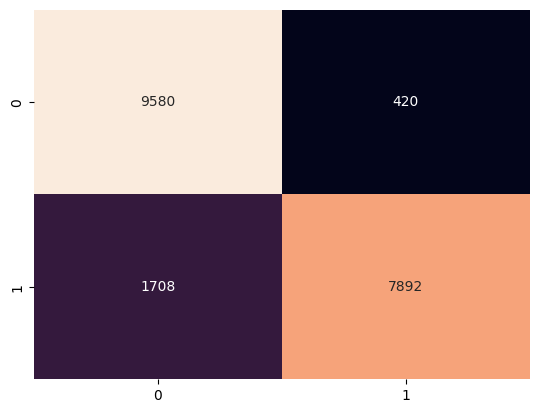

In [ ]:
cm = confusion_matrix(y_test_shuffled, grid_predictions)
sns.heatmap(cm, annot=True, fmt='g', cbar=False)
plt.show()

In [ ]:
cm

array([[9580,  420],
       [1708, 7892]], dtype=int64)

Comparing the two confusion matrices, we can observe the following changes:

**Before the hyperparameter search:**

- True Negatives (TN): `9559`
- False Positives (FP): `441`
- False Negatives (FN): `1464`
- True Positives (TP): `8136`

**After the hyperparameter search:**

- True Negatives (TN): `9580`
- False Positives (FP): `420`
- False Negatives (FN): `1708`
- True Positives (TP): `7892`

**Observations:**

- There is a slight improvement in true negatives (TN), increasing from 9559 to 9580.
- There is a reduction in false positives (FP), decreasing from 441 to 420.
- There is an increase in false negatives (FN), rising from 1464 to 1708.
- There is a decrease in true positives (TP), dropping from 8136 to 7892.

Therefore, after applying the hyperparameter search, the model tends to correctly classify more samples as non-pedestrians (increase in true negatives) and fewer samples as false positives (decrease in false positives). However, there is also an increase in false negatives, indicating that the model incorrectly classifies more samples as non-pedestrians when they are actually pedestrians. This suggests that the hyperparameter tuning has impacted the model's ability to generalize, but additional adjustments may still be needed to improve performance in terms of pedestrian classification.


In [ ]:
print(classification_report(y_test_shuffled, grid_predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     10000
         1.0       0.95      0.82      0.88      9600

    accuracy                           0.89     19600
   macro avg       0.90      0.89      0.89     19600
weighted avg       0.90      0.89      0.89     19600



**Before the hyperparameter search:**

- Precision for class 0 (non-pedestrians): `0.87`
- Recall for class 0: `0.96`
- F1-score for class 0: `0.91`
- Precision for class 1 (pedestrians): `0.95`
- Recall for class 1: `0.85`
- F1-score for class 1: `0.90`
- Accuracy: `0.90`

**After the hyperparameter search:**

- Precision for class 0 (non-pedestrians): `0.85`
- Recall for class 0: `0.96`
- F1-score for class 0: `0.90`
- Precision for class 1 (pedestrians): `0.95`
- Recall for class 1: `0.82`
- F1-score for class 1: `0.88`
- Accuracy: `0.89`

**Observations:**

- After the hyperparameter search, we observe a decrease in recall for class 1 (pedestrians), from 0.85 to 0.82.
- There is also a slight decrease in precision for class 0 (non-pedestrians), from 0.87 to 0.85.
- The F1-score for class 0 remains relatively stable, decreasing only slightly from 0.91 to 0.90.
- The F1-score for class 1 shows a more notable decrease, from 0.90 to 0.88.
- The overall accuracy of the model slightly decreases from 0.90 to 0.89 after the hyperparameter search.

Therefore, we will choose the initially trained model, which has a better balance in terms of prediction quality.

In [ ]:
import joblib

# Guardar el modelo resultante
joblib.dump(grid_search, 'modelo_entrenado.pkl')

# Realizar predicciones con el modelo y guardarlas
grid_predictions = grid_search.predict(X_test_shuffled)
joblib.dump(grid_predictions, 'predicciones.pkl')

['predicciones.pkl']

With this last line, we save our model so that it can be used later to generate predictions.

In [ ]:
# Cargar el modelo
modelo_cargado = joblib.load('modelo_entrenado.pkl')

# Cargar las predicciones
predicciones_cargadas = joblib.load('predicciones.pkl')